# Classification of NPS using ULMFit Model

## ULMFit Model Architecture

## Data

In [ ]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive

     |████████████████████████████████| 993kB 6.6MB/s 


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/open?id=17o-x0aaMYhxwPKSV6fcNz96lulbVCG5r' # The shareable link
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

17o-x0aaMYhxwPKSV6fcNz96lulbVCG5r


In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import csv
from sklearn.model_selection import train_test_split

In [ ]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('NPS raw data.txt')  
data = pd.read_csv('NPS raw data.txt', header=0, encoding='utf-8',delimiter='|')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving all_verbatim_less_category.csv to all_verbatim_less_category.csv


In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import csv
from sklearn.model_selection import train_test_split

In [ ]:
#data = pd.read_csv('./dataset/nps_cleaned.csv', header=0, encoding='utf-8')
#data = pd.read_csv('./nps_cleaned.csv', header=0, encoding='utf-8')
#data = pd.read_csv('./NPS_all_comments.csv', header=0, encoding='utf-8')
data = pd.read_csv('./all_verbatim_less_category.csv', header=0, encoding='utf-8')

In [ ]:
data.head(5)

,Identity,Platform,AccountCountry,CustomerID,StartDate,EndDate,Recommend,Verbatim,Sentiment1,Cat1_1st_Level,Cat1_2nd_Level,Sentiment2,Cat2_1st_Level,Cat2_2nd_Level,Unnamed: 14
0,866,\tTelogis,\t,\t3e855154-e10d-11e7-8f10-065d6e9c3b17,\tMar 20 2018 6:26PM,\tMar 20 2018 6:26PM,\t3,\tIt is not dependable - I cant trust that th...,\tNEG,\tReliability,\tReports,\t,\t,\t,NaN
1,888,\tTelogis,\t,\te603441e-7b69-11e6-8629-06544a741b3f,\tFeb 6 2018 6:10PM,\tFeb 6 2018 6:11PM,\t5,\tno history to see where they drove,\tNEG,\tProduct Features,\tLack of features,\t,\t,\t,NaN
2,897,\tTelogis,\t,\t624ea360-8d93-4ce2-bc7e-9360f91ac842,\tMar 14 2018 12:45PM,\tMar 14 2018 12:46PM,\t4,\tLogin page is confusing now....,\tNEG,\tUsability,\tLogin,\t,\t,\t,NaN
3,1008,\tTelogis,\t,\t4f836fd7-c29d-461c-8366-3548dbfe5fbb,\tMar 6 2018 5:40PM,\tMar 6 2018 5:40PM,\t2,\tnot user friendly,\tNEG,\tUsability,\tGeneric,\t,\t,\t,NaN
4,1011,\tTelogis,\t,\tf26854da-6d92-11e7-8082-065d6e9c3b17,\tMar 8 2018 2:37PM,\tMar 8 2018 2:38PM,\t4,\tNot as accurate,\tNEG,\tReliability,\tGeneric,\t,\t,\t,NaN


In [ ]:
data['Verbatim'] = data['Verbatim'].str.replace('\t','')
data['Cat1_1st_Level'] = data['Cat1_1st_Level'].str.replace('\t','')

In [ ]:
data[['Verbatim','Cat1_1st_Level']].head(5)

,Verbatim,Cat1_1st_Level
0,It is not dependable - I cant trust that the ...,reliability
1,no history to see where they drove,product features
2,Login page is confusing now....,usability
3,not user friendly,usability
4,Not as accurate,reliability


In [ ]:
data['Cat1_1st_Level'].str.lower().unique()
data['Cat1_1st_Level'] = data['Cat1_1st_Level'].str.lower()

In [ ]:
main_categories =   ['reliability', 'product features', 'usability', 'performance', 'contract', 'customer support', 'customer success']

In [ ]:
data = data[['Verbatim','Cat1_1st_Level']]

### Splitting data into labels and features

Labels are the data which we want to predict and features are the data which are used to predict labels.

In [ ]:
# delete duplicate verbatim
data.drop_duplicates(keep=False,inplace=True)

In [ ]:
y = data['category'].str.lower()
X = data['Verbatim']
data = pd.DataFrame(y).join(pd.DataFrame(X))
data.to_csv('./data.csv', index=False, header=True)

In [ ]:
df_stats = data.groupby(['Cat1_1st_Level']).count()
df_stats.columns = ['count']
df_stats

,count
Cat1_1st_Level,
contract,3680
customer success,405
customer support,4118
performance,4239
product features,29756
reliability,20104
usability,14052


In [ ]:
main_categories.sort()
main_categories

['contract',
 'customer success',
 'customer support',
 'performance',
 'product features',
 'reliability',
 'usability']

In [ ]:
df_stats['category'] = main_categories
df_stats

,count,category
Cat1_1st_Level,,
contract,3680,contract
customer success,405,customer success
customer support,4118,customer support
performance,4239,performance
product features,29756,product features
reliability,20104,reliability
usability,14052,usability


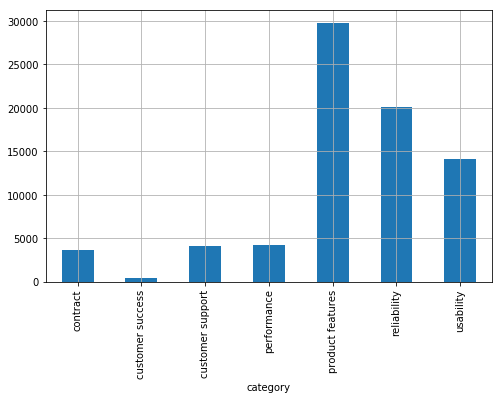

In [ ]:
df_stats.plot(x = 'category', 
              y = 'count', 
              kind = 'bar', 
              legend = False, 
              grid = True, 
              figsize = (8,5))

### Pretrained language models

ULMFit uses its own pretrained language model wikitext-103 that can be conveniently downloaded from the fastai database hosted on AWS.

### Preprocess training data

In [ ]:
# Check that the latest 1.0.0 build of PyTorch has been installed 
# alongside fastai
import torch
print("Cuda available" if torch.cuda.is_available() is True else "CPU")
print("PyTorch version: ", torch.__version__)

Cuda available
PyTorch version:  1.1.0


In [ ]:
from fastai import *
from fastai.text import *
path = './'

In [ ]:
data.head(5)

,Verbatim,Cat1_1st_Level
0,It is not dependable - I cant trust that the ...,reliability
1,no history to see where they drove,product features
2,Login page is confusing now....,usability
3,not user friendly,usability
4,Not as accurate,reliability


In [ ]:
#data_lm = TextDataBunch.from_csv(path, 'data.csv') # load LM from CSV

y = data['Cat1_1st_Level']
X = data['Verbatim']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
df_train = pd.DataFrame(y_train).join(pd.DataFrame(X_train))
df_valid = pd.DataFrame(y_test).join(pd.DataFrame(X_test))

data_lm = TextDataBunch.from_df(path, train_df=df_train, valid_df=df_valid, bs=32) # load LM from DF

In [ ]:
data_lm.save('data_lm')

In [ ]:
ls

data.csv  data_lm  data_save.pkl  NPS_all_comments.csv  sample_data/  tmp


Next time we launch this notebook, we can skip the cell above that took a bit of time (and that will take a lot more when you get to the full dataset) and load those results like this:

In [ ]:
#data = TextDataBunch.load(path)

### Tokenization

The first step of processing we make texts go through is to split the raw sentences into words, or more exactly tokens. The easist way to do this would be to split the string on spaces, but we can be smarter:


*   we need to take care of punctuation
*   some words are contractions of two different words, like isn't or don't
*   we may need to clean some parts of out texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch



In [ ]:
data_lm.show_batch()

text,target
"xxbos xxmaj my first issue is i do n't believe i was properly xxunk on the features just prior to purchasing two of your road assistance packages ... xxmaj had i known what i know now , i would not have made the purchase ... i recently retired 30 years military service , just prior to my retirement i ended up in a serious accident resulting in traumatic brain injury",product features
xxbos xxmaj it would be better with updated google maps . a region we do a lot of work in has been developed extensively since the last update on google . xxmaj it currently just shows as a mass of trees with no streets or houses . xxmaj that presents a challenge at times . xxmaj there are also a few other kinks you need to work out or be,usability
"xxbos xxmaj july xxunk i was in a bad accident . xxmaj within 30 seconds of the hit , i heard this voice asking me if i was in an accident and do i need the police and paramedics . within 5 minutes or less the police and paramedics we there and helping me and the other lady in her car . xxmaj th xxmaj hum lady stayed with me",product features
"xxbos the xxup gps is xxup terrible . xxmaj does n't give turn directions in advance . xxmaj if you 're driving on a highway at 75 miles per hour , the xxup gps only gives you a one mile advance notice to make a turn . xxmaj if you 're in the left hand passing lane , that gives you 60 seconds to get into the right lane to",reliability
xxbos i do not appreciate embrace 's sales / marketing tactics . xxmaj it is incredibly difficult to cancel a subscription . xxmaj they make you give a cc when you purchase the car and then they are able to charge it whenever the subscription time is up . i am getting emails to update a cc on a car that i sold 5 years ago .,product features


### **Numericalizatio**

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at list twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token ```UNK```.

The correspondance from ids tokens is stored in the vocab attribute of our datasets, in a dictionary called itos



In [ ]:
data_lm.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.']

In [ ]:
data_lm.train_ds[0][0]

Text xxbos i can track where my people are and compare it to job duration from a planning and actual and validate xxunk data for payroll purposes . xxmaj and i find many xxunk .

In [ ]:
data_lm.train_ds[0][0].data[:10]

array([   2,   18,   66,  112,  119,   46,  218,   27,   12, 1391])

## With the data block API

We can use the data block API with NLP and have a lot more flexibility than waht the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows mre flexibility, and if you're not using the defaults from fastai, the variaous arguments to pass will appear in the step they're revelant, so it'll be more readable.

In [ ]:
#data = pd.read_csv('./NPS_all_comments.csv', header=0, encoding='utf-8')
data = pd.read_csv('./all_verbatim_less_category.csv', header=0, encoding='utf-8')
data.head(5)

,Platform,Verbatim,category
0,1 – Reveal,Could use some upgrades,Product Features
1,1 – Reveal,Because your asking me to take a stupid survey...,Usability
2,1 – Reveal,There is no service in the Crowders Mountain a...,Reliability
3,1 – Reveal,tracking drivers,Reliability
4,1 – Reveal,- Constantly losing bluetooth connection - Po...,Reliability


In [ ]:
#data = (TextList.from_csv(path, 'NPS_all_comments.csv', col='Verbatim').split_from_df(cols=0).label_from_df(cols=2).databunch())

## Transfer Learning Stages

This notebook utilizes the refactored and updated version (v1) of ULMFit as implemented in the fastai GitHub repository. This requires an install of Pytorch 1.0.0 (released on December 7, 2018) to run since its development intended to move alongside PyTorch's own development cycle in the future. It is recommended to run this entire notebook in a virtual environment to avoid clashes with pre-existing installs of PyTorch.

The refactored code for ULMFit is much more high-level and abstracted than the original version that was used in the paper, so it doesn't make sense to rewrite the data manipulation code for text handling and tokenization from the ground up. We can take advantage of the powerful transfer learning functionality that is baked into ULMFit (obtained after months of fine-tuning and refactoring the source code by Fast.ai) instead!

### Step1: Preprocess data for language model fine-tuning

The TextLMDataBunch [source] class returns a "Databunch" type of object that is a custom object defined in fastai.text's API. Note that according to this class definition, a significant amount of data pre-processing is going on under the hood.
* Initialize the language model with the pre-trained vocabulary's weights
* Create a custom data loader that "batchifies" the target task's vocabulary, i.e. split it up into batches for processing on the GPU
* Introduce randomness into the batches, but without breaking up the sentence sequences using techniques borrowed from language modeling.
* Tokenize the target task's vocabulary and increase the efficiency of tokenization (for large tasks) using multi-threading


In [ ]:
doc(TextLMDataBunch)

In [ ]:
data = pd.read_csv('./NPS_all_comments.csv', header=0, encoding='utf-8')

In [ ]:
# delete duplicate verbatim
data.drop_duplicates(keep=False,inplace=True)

In [ ]:
y = data['category'].str.lower()
X = data['Verbatim']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
df_train = pd.DataFrame(y_train).join(pd.DataFrame(X_train))
df_valid = pd.DataFrame(y_test).join(pd.DataFrame(X_test))

In [ ]:
df_train.head(5)

,category,Verbatim
10719,usability,Poor responses regarding critical issues. can...
2972,usability,EASY SITE TO NAVIGATE
3323,reliability,"Easy to use, good price, accurate"
5570,reliability,half the trucks don't work
5596,customer service,hard to contact anyone in regards to gps not w...


In [ ]:
df_valid.head(5)

,category,Verbatim
1336,reliability,confusing...had to reset password
15756,usability,Very hard to use.
7494,product features,It is not nearly as user friendly as it could ...
306,reliability,Accurate information
4401,product features,Gives many error messages


Creating a dataset from your raw texts is very simple. The library provides very easy to use API’s, depending on how our data is structured, to create a data class TextDataBunch for text processing, from_csv, from_folder,from_df refer to documentation for more details. Here we’ll use the method from_df of the TextLMDataBunch to create a language model specific data bunch:

In [ ]:
data_lm = TextLMDataBunch.from_df(path, train_df=df_train, valid_df=df_valid, bs=32)

In [ ]:
data_lm.show_batch()

idx,text
0,"have . xxbos it ties one to a single car . what if the person has 3 cars ? xxbos i do no have time for this xxbos i have not found many instances that i need the mbrace . i use my iphone for more of the needs instead of mbrace xxbos i have never used the mbrace system , therefore , i can not rate the functionality ."
1,"board computer monitoring the other features are on my phone . xxmaj the extra costs is n't worth what 's provided . i will cancel my subscription when it expires next year . xxbos i like the security of accident notification , and roadside assistance if necessary . xxbos i do n't use it much , but like insurance , it 's comforting to know you have it ! xxbos"
2,"tie into xxmaj google maps so i can see terrain , and street views xxbos ease of use xxbos xxmaj it 's like having a xxunk xxunk xxbos xxmaj easy to work with xxbos xxmaj to be able to see where the vehicle is at all times . xxbos xxmaj the map is effective and as close to real time as a tracking map can be . xxmaj the only"
3,. xxbos it really helps ensure my familys safety . xxbos xxmaj child safety xxbos xxmaj internet connection and apps are so slow - no patience for it xxbos xxmaj simple easy accurate ! xxbos i have not had good responses when i have tried to use this service . xxbos xxmaj no one has been able to get it to work as it is supposed to on either of
4,work i know where i am . xxbos xxmaj have n’t used much xxbos excellent performance xxbos excellent reports xxbos xxmaj location are not always accurate and there is a big delay in driving xxunk xxbos xxmaj hum is watching my car for me xxbos i feel much more secure knowing i have a way to stay


**Vocabulary**: List of unique possible tokens is called the vocabulary. Listing below first 20 unique tokens in order of frequency:

In [ ]:
data_lm.vocab.itos[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.',
 'the',
 'to',
 'i',
 'it',
 'and',
 'is',
 'not',
 ',',
 'a',
 'of']

### **Numericalizatio**
Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at list twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token UNK.

In [ ]:
data_lm.train_ds[0][0].data[:10]

array([  2,   5, 623,  12,  21,  16,  87,  13,  24,  10])

**Save and Load**: We can save the data bunch after the pre-processing is done. We can load as well whenever we need.

In [ ]:
data_lm.save('tmp_lm')

### Step 2: Create Language Model

![image.png](attachment:image.png)

We only need to run the above tokenization step once, and save the data. All the data goes to a local folder named tmp/. For a large added vocabulary, the above tokenization step can take a while, hence we save them and restart the notebook from the next cell (if we close our session).

The tokenization technique used by fastai.text is quite advanced, and uses quite a few tricks to capture semantic meaning from the text. Unlike typical NLTK-type tokenization, here we are not converting the Verbatim to lowercase and removing information from the base text - that would result in a tremendous loss of information that our model could use to gather an understanding of our new task's vocabulary.

Instead, a number of added tokens are applied so that minimal information is lost. A full list of all the tokenization rules used are [here](https://docs.fast.ai/text.transform.html#Rules).

As an example, the xxmaj token [source](https://github.com/fastai/fastai/blob/1c5c007e10a187f4a048a3ee8137016534259768/fastai/text/transform.py#L71) indicates that there is capitalization of the word, either in part or in full. "The" will be tokenized as "xxmaj the". For words that are full capitalized, such as "I AM SHOUTING"; it is tokenized as "xxup i xxup am xxup shouting". The tokenizer uses spaCy's underlying tokens, but adds tags in a very smart way that balances capturing semantic meaning while reducing the number of overall tokens, so it is both powerful and efficient.

The tokenization process described above is highly efficient, in part thanks to the power of SpaCy and also due to the multi-threading wrappers implemented by Fast.ai on top of Spacy's tokenizer. As a result, a really large language model's vocabulary (of millions of words) can also be effectively tokenized in a reasonable time.


### Define learner object for language model finetuning

We define a learner object that uses the tokenized language model data, that is organized into batches for the GPU, and feed it a pre-trained language model.

This is the first stage of training, where we use the pre-trained language model weights and fine-tune it with the training data of IMDb movie reviews. When we create a learner, we have to pass in two things:

* The data: our language model data (data_lm)
* A pre-trained model: here, the pre-trained model is the Wikitext 103 model that will be downloaded for you from fastai.
    
We use the wt_103_v1 model that was refined after re-training using the more efficient fastai v1 library. The data (lstm_wt103.pth) is downloaded through an AWS-hosted link (accessed through the fastai.datasets interface), and stored locally. All the data in the language model file is numericalized and stored in a way that the learner can efficiently pick up tokens in float form. In addition to the language model, there is also an additional pickle object itos_wt103.pkl that is similar to the torchtext definition of "integer-to-string" - this contains the list of unique tokens in word form, so that we can map the tokens back to strings if necessary.

In [ ]:
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.3)
#learn = language_model_learner(data_lm, arch=Transformer, drop_mult=0.1)

drop_mult , a hyper-parameter ,used for regularization, sets the amount of dropout. If the model is over-fitting increase it, if under-fitting, you can decrease the number.

### Print the structure of the language model RNN

We can examine the architecture of the 3-layer LSTM used in ULMFit as shown below. For the language model fine-tuning, we define the embeddings based on the the target task vocabulary size. A single linear output layer is defined that updates the weights once we pass the input through the network.

In [ ]:
list(learn.model.children())

### Find the optimum learning rate

fastai.train [source](https://github.com/fastai/fastai/blob/050080be574cb1260462bbd03e9600e43e7a54b1/fastai/train.py#L23) provides a convenient utility to search through a range of learning rates to find the optimum one for our dataset.

The idea is that our optimization function needs to use a learning rate that is an order of magnitude below the point at which the loss starts to diverge. We can quickly find this as shown below.

**How to fine-tune the pre-trained model on our movie review data?** <br>
Learning rate hyper-parameter is one of the most important parameters to train a model. Fast.ai provides a convenient utility (learn.lr_find) to search through a range of learning rates to find the optimum one for our dataset. Learning rate finder will increase the learning rate after each mini-batch. Eventually, the learning rate is too high that loss will get worse. 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


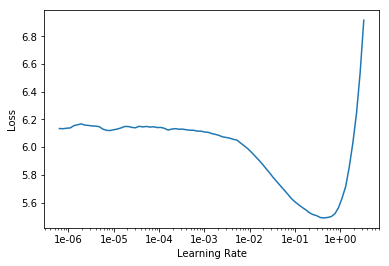

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
# free CUDA cache
#torch.cuda.empty_cache()

### Training the model:

We start training the model with learning rate 1e-2 using fit_one_cycle.

In [ ]:
max_lr = 1e-1
min_lr = 1e-2
lr = slice(min_lr, max_lr)

In [ ]:
#learn.fit_one_cycle(1, 1e-47/25)
learn.fit_one_cycle(cyc_len = 1,
                    max_lr = 1e-2,        # learning rate
                    div_factor = 20,    # factor to discount from max
                    moms =(0.8, 0.7),   # momentums
                    pct_start = 0.1     # where the peak is at
                   )

epoch,train_loss,valid_loss,accuracy,time
0,3.728774,3.620115,0.301572,02:05


It trained last layers and basically left most of the model exactly as it was. But what we really want is to train the whole model. Normally after we fine-tune the last layers, the next thing we do is we go unfreeze (unfreeze the whole model for training) and train the whole thing.

In [ ]:
learn.save_encoder('enc_lstm')
learn.save('model_lstm')

fast.ai library uses latest techniques from deep learning research and one cycle learning is from one of the recent paper and turned out to be both more accurate and faster than any previous approach. First argument ‘1’ is number of epoch runs . We get an accuracy of 30.3% after running just one epoch.

It trained last layers and basically left most of the model exactly as it was. But what we really want is to train the whole model. Normally after we fine-tune the last layers, the next thing we do is we go unfreeze (unfreeze the whole model for training) and train the whole thing.

In [ ]:
#learn.unfreeze()
#learn.fit_one_cycle(1, 1e-47/25)

Accuracy = 0.3 means the model is guessing the next word of the verbatim correctly about a third of the time. That sounds like a pretty high number. So it’s a good sign that my language model is doing pretty well.

### Predicting with Language Model

To evaluate our language model, we can now run learn.predict and pass in the start of a sentence and specify the number of words we want it to guess.

In [ ]:
learn.predict('Not entirely user friendly for a large corporation.', n_words=30)

"Not entirely user friendly for a large corporation. Purpose was the job of criticism . Service logins , people , want of people on the i track the drive of the vehicle . There 's"

Actual comments from our customer. Pikced up from slack channel 
```
Why did you change the fuel import process? I use YOUR template, but now I have to change 81 rows because it doesn't import correctly.
```
![image.png](attachment:image.png)

In [ ]:
learn.save_encoder('fine_enc')

### Creating the classifier

Now we’re ready to create our classifier. Step one, is to create a data bunch, TextClasDataBunch, passing the vocab from the language model to make sure that this data bunch is going to have exactly the same vocab. Batch size bs to be used is according to the GPU memory you have available, for a 2GB GPU around bs=5 will work fine. You can find whatever batch size fits on your card and use it accordingly.

In [ ]:
# Classifier model data
data_clas = TextClasDataBunch.from_df('./'
                                      ,train_df=df_train
                                      ,valid_df=df_valid
                                      ,vocab=data_lm.train_ds.vocab
                                      ,bs=32)

In [ ]:
data_clas.show_batch()

text,target
"xxbos xxmaj my first issue is i do n't believe i was properly xxunk on the features just prior to purchasing two of your road assistance packages ... xxmaj had i known what i know now , i would not have made the purchase ... i recently retired 30 years military service , just prior to my retirement i ended up in a serious accident resulting in traumatic brain injury",product features
"xxbos i have absolutely disappointed by the service i received from dealership management and service department : \ \ xxmaj two weeks ago , when my wife drove the car one of the back tiers was exploded in the middle of the street and we had to tow the car to our home because there is no spare tire available on the vehicle and also it was impossible to drive",customer support
"xxbos xxmaj my experience with this company has been very poor . xxmaj there is a serious lack in communication . xxmaj our account manager was changed and we were nt notified , then the new manager was difficult , almost impossible to get in contact with in any manner . xxmaj that manager made several promises and never followed through on any of them . xxmaj then , that",customer success
xxbos xxmaj using the xxup sos button as lo - jack is a great feature and i feel more secure in knowing that i can locate my car at any time . xxmaj having the roadside assistance button reset and activated is a must so that you can easily connect with the nearest xxup mb technician . ( xxmaj although the roadside assistance number is under the visor . ),product features
"xxbos xxmaj couple of things need clarification . xxmaj this car is driven mainly here in town and will have only a few thousand miles on it a year . xxmaj we have a 2016 xxup gle 350 which is our road car . xxmaj so , my experiences will be mainly associated with that vehicle . \ xxmaj the people with whom i have interacted on the service have",customer support


Finally we will create a text classifier learner. Load in our pre train model, the encoding part we saved earlier ‘fine_enc’.

In [ ]:
# Classifier
classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3)
#classifier = text_classifier_learner(data_clas, Transformer, drop_mult=0.5)
classifier.load_encoder('fine_enc')
#classifier.load_encoder('enc_lstm')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (53447 items)
x: TextList
xxbos xxmaj although i have not used it in the past few months , the times i used it in the past with my current and past xxmaj mercedes have been very satisfactory .,xxbos xxmaj the hum is great at telling you what is wrong with the xxmaj car . xxmaj it provided me with roadside assistance , a jump for a battery etc . a great device to have .,xxbos it ties one to a single car . what if the person has 3 cars ?,xxbos i do no have time for this,xxbos i have not found many instances that i need the mbrace . i use my iphone for more of the needs instead of mbrace
y: CategoryList
product features,product features,usability,usability,product features
Path: .;

Valid: LabelList (22907 items)
x: TextList
xxbos too many steps for the driver,xxbos length of contracts , price per xxunk,xxbos i think the hard braking is wrong . i do nt xxunk on my brakes / brake fast & get marked for it often .,xxbos xxmaj most cars hav

Again, we follow the same procedure to find the learning rate and train the model.

In [ ]:
classifier.freeze()
classifier.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


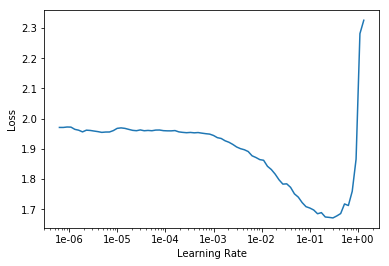

In [ ]:
classifier.recorder.plot()

In [ ]:
classifier.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.060264,0.900145,0.684201,01:40


Loss Plot: Let us plot the loss while training the model:

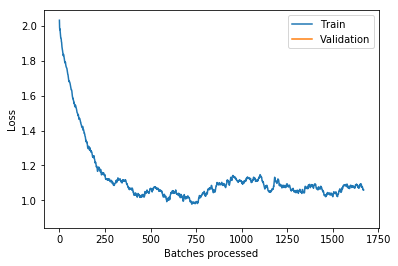

In [ ]:
classifier.recorder.plot_losses()

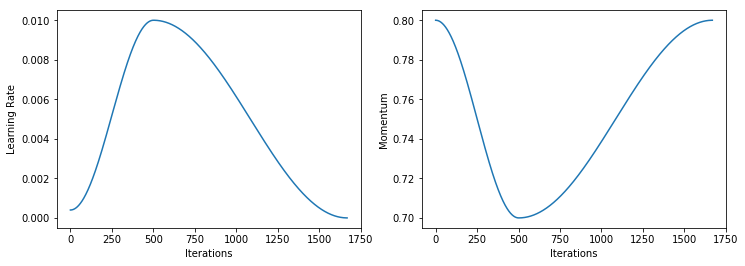

In [ ]:
classifier.recorder.plot_lr(show_moms=True)

In [ ]:
classifier.save('first')

In [ ]:
classifier.load('first')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (53447 items)
x: TextList
xxbos xxmaj although i have not used it in the past few months , the times i used it in the past with my current and past xxmaj mercedes have been very satisfactory .,xxbos xxmaj the hum is great at telling you what is wrong with the xxmaj car . xxmaj it provided me with roadside assistance , a jump for a battery etc . a great device to have .,xxbos it ties one to a single car . what if the person has 3 cars ?,xxbos i do no have time for this,xxbos i have not found many instances that i need the mbrace . i use my iphone for more of the needs instead of mbrace
y: CategoryList
product features,product features,usability,usability,product features
Path: .;

Valid: LabelList (22907 items)
x: TextList
xxbos too many steps for the driver,xxbos length of contracts , price per xxunk,xxbos i think the hard braking is wrong . i do nt xxunk on my brakes / brake fast & get marked for it often .,xxbos xxmaj most cars hav

### Fine-Tune further

To improve the accuracy further, fast.ai provides some more tricks;freeze_to. Don't unfreeze the whole thing but to unfreeze one layer at a time. The below approach works very well and gives incredible results.

* unfreeze the last two layers freeze_to(-2), train it a little bit more
* unfreeze the next layer freeze_to(-3), train it a little bit more
* unfreeze the whole thing unfreeze(), train it a little bit more

In [ ]:
classifier.lr_find(start_lr=1e-05, end_lr=1e00)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


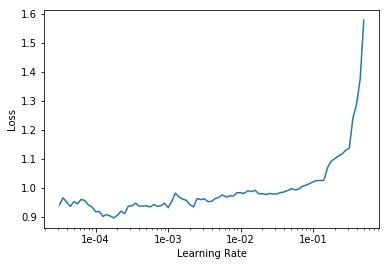

In [ ]:
classifier.recorder.plot()

In [ ]:
classifier.freeze_to(-2)
classifier.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.875652,0.764603,0.732134,01:52


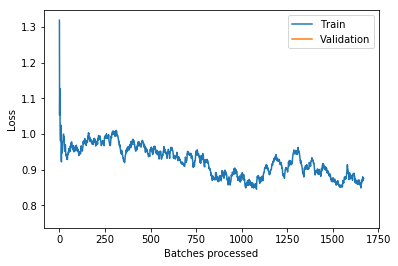

In [ ]:
classifier.recorder.plot_losses()

In [ ]:
classifier.save('second')

In [ ]:
classifier.save('second')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (53447 items)
x: TextList
xxbos xxmaj although i have not used it in the past few months , the times i used it in the past with my current and past xxmaj mercedes have been very satisfactory .,xxbos xxmaj the hum is great at telling you what is wrong with the xxmaj car . xxmaj it provided me with roadside assistance , a jump for a battery etc . a great device to have .,xxbos it ties one to a single car . what if the person has 3 cars ?,xxbos i do no have time for this,xxbos i have not found many instances that i need the mbrace . i use my iphone for more of the needs instead of mbrace
y: CategoryList
product features,product features,usability,usability,product features
Path: .;

Valid: LabelList (22907 items)
x: TextList
xxbos too many steps for the driver,xxbos length of contracts , price per xxunk,xxbos i think the hard braking is wrong . i do nt xxunk on my brakes / brake fast & get marked for it often .,xxbos xxmaj most cars hav

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


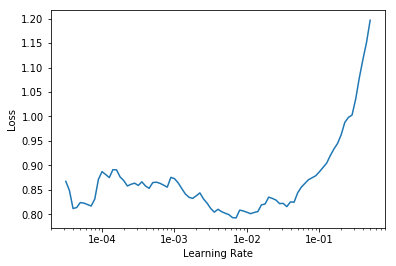

In [ ]:
classifier.lr_find(start_lr=1e-05, end_lr=1e00)
classifier.recorder.plot()

In [ ]:
max_lr = 1e-16/5
#lr = slice(1e-37/10, max_lr)

In [ ]:
classifier.freeze_to(-3)
classifier.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.775582,0.699013,0.753132,02:52


In [ ]:
classifier.save('third')

In [ ]:
classifier.load('third');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


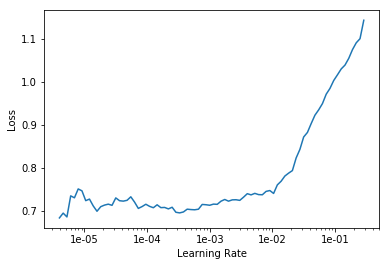

In [ ]:
classifier.lr_find(start_lr=1e-06, end_lr=1e00)
classifier.recorder.plot()

In [ ]:
classifier.unfreeze()
classifier.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.680407,0.690294,0.755359,03:35
1,0.676751,0.683664,0.759026,04:02
2,0.550101,0.687051,0.759986,03:54


In [ ]:
classifier.save('final')

In [ ]:
classifier.show_results()

text,target,prediction
xxbos xxmaj network xxmaj fleet is a good system to use for the most part but the reason i give the rating a 6 is because recently i ’ve contacted tech support to try and resolve the yellow xxunk issue ( on xxmaj map xxmaj xxunk ) with xxmaj pa xxmaj map unit # xxunk . xxmaj they sent me out a new xxup gps unit around xxmaj november 19,customer support,customer support
"xxbos xxmaj posted speed limits are wrong , example : it has show 45 xxup mph speed limits , when the posted speed is 55 xxup mph . xxmaj if the vehicle is in a school zone it show the speed of the school zone even when not active , example : posted speed limit on the road is 45 xxup mph and the school zone is 20 when active",usability,reliability
"xxbos xxmaj solid site but could use some fine tuning when it comes to xxmaj landmarks , xxmaj geofences , and xxmaj reporting . xxmaj landmarks xxmaj types : xxmaj the ability to create custom / user specific landmark types , much like you are able to do with xxmaj landmark xxmaj categories . xxmaj map xxmaj view - xxmaj the ability to view landmarks by "" xxmaj category """,usability,product features
"xxbos i 've used the service since i 've had it a few times , the latest was 8 / 29 / 18 . i was within 1 / 2 mile of my home and hit a bull that was in the road . i called and the call was answered but the lady that answered continued to ask if i needed xxup emts and i kept telling her no",reliability,customer support
"xxbos xxmaj the xxmaj mbrace xxmaj smartphone app is unreliable . xxmaj it takes forever to launch . xxmaj it regularly does xxup not start my car and gives me an erroneous error saying i do n't have enough fuel or my windows are open , when the tank is xxup full and the windows are xxup up . \ \ xxmaj additionally , the application is lacking features which",product features,reliability


In [ ]:
from fastai.vision import *

In [ ]:
interp = ClassificationInterpretation.from_learner(classifier)

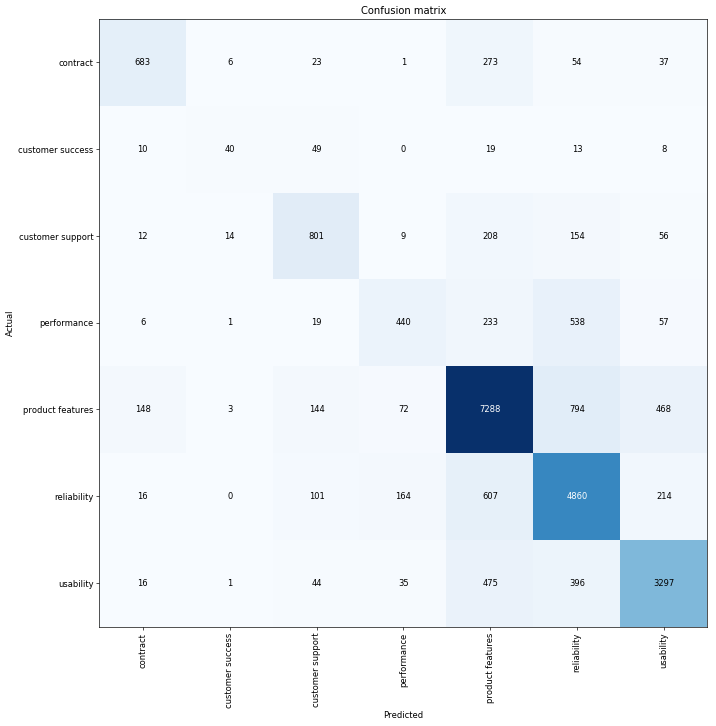

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
pred,y,losses = classifier.get_preds(with_loss=True)

In [ ]:
interp = ClassificationInterpretation(classifier, pred, y, losses)

In [ ]:
interp.most_confused()

[('product features', 'reliability', 204),
 ('customer support', 'customer service', 183),
 ('usability', 'reliability', 142),
 ('reliability', 'product features', 116),
 ('reliability', 'customer service', 91),
 ('reliability', 'usability', 91),
 ('performance', 'reliability', 76),
 ('customer service', 'reliability', 75),
 ('product features', 'usability', 72),
 ('customer service', 'customer support', 57),
 ('usability', 'customer service', 43),
 ('usability', 'product features', 42),
 ('product features', 'customer service', 40),
 ('customer success', 'customer service', 34),
 ('reliability', 'performance', 32),
 ('customer service', 'product features', 30),
 ('customer support', 'reliability', 26),
 ('contract', 'customer service', 21),
 ('customer service', 'usability', 20),
 ('performance', 'product features', 19),
 ('customer support', 'usability', 13),
 ('performance', 'customer service', 13),
 ('sales', 'customer service', 13),
 ('performance', 'usability', 12),
 ('contract',

In [ ]:
print(2e-2,1e-3,1e-1,1e-2)

0.02 0.001 0.1 0.01


In [ ]:
print(1e-3/(2.6**4),1e-3)

2.1882987290360978e-05 0.001
